In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a CNF expression.
        Args:
            The CNF expression
    """
    def __init__(self, clauses):
        self.clauses = clauses

    def is_correct(self, sample):
        """Verifies a SAT solution against this object's
        CNF expression.
            Args:
               sample (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        sample = [bool(int(x)) for x in sample][::-1]
        for clause in self.clauses:
            clause_eval = False
            for literal in clause:
                if literal < 0:
                    lit_eval = not sample[-literal-1]
                else:
                    lit_eval = sample[literal-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [3]:
v = Verifier([[1, -2], [-1, 2]])   
v.is_correct('11')

True

In [4]:
def oracle(expression, clauses, variables):
    vars = QuantumRegister(variables, "vars")
    cls = QuantumRegister(clauses, "cls")
    out = QuantumRegister(1, "out")
    qc = QuantumCircuit(vars, cls, out)
    qc.x(variables+clauses)
    qc.h(variables+clauses)
    c = 0
    for clause in expression:
        controls = []
        for lit in clause:
            if lit > 0:
                qc.x(lit-1)
            controls.append(abs(lit)-1)
        qc.mcx(controls, variables+c)
        qc.x(variables+c)
        for lit in clause:
            if lit > 0:
                qc.x(lit-1)
        c = c+1;
        qc.barrier()
    controls = []
    for i in range(clauses):
        controls.append(variables+i)
    qc.mcx(controls,variables+clauses)
    qc.barrier()
    c = clauses-1
    for clause in expression[::-1]:
        qc.x(variables+c)
        for lit in clause:
            if lit > 0:
                qc.x(lit-1)
        controls = []
        for lit in clause:
            controls.append(abs(lit)-1)
        qc.mcx(controls, variables+c)
        for lit in clause:
            if lit > 0:
                qc.x(lit-1)
            controls.append(abs(lit)-1)
        c = c-1;
        qc.barrier()

    return qc

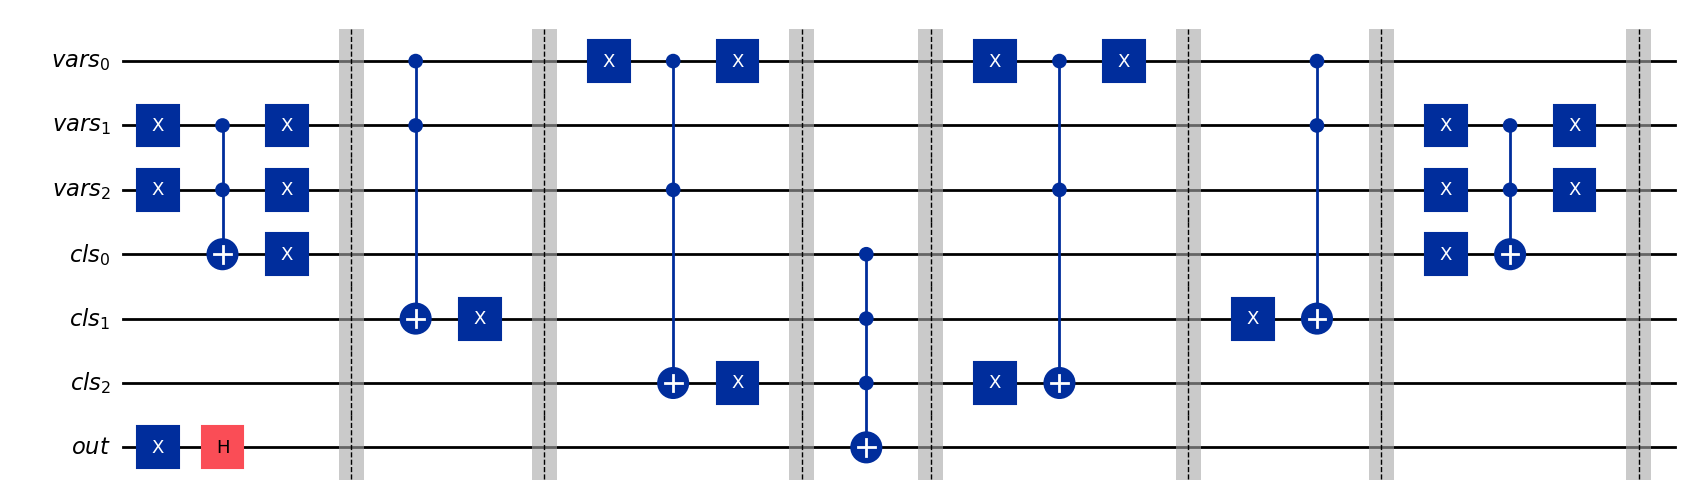

In [5]:
test = [[2, 3], [-1, -2], [1, -3]]
q = oracle(test, 3, 3)
q.draw('mpl')

In [6]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

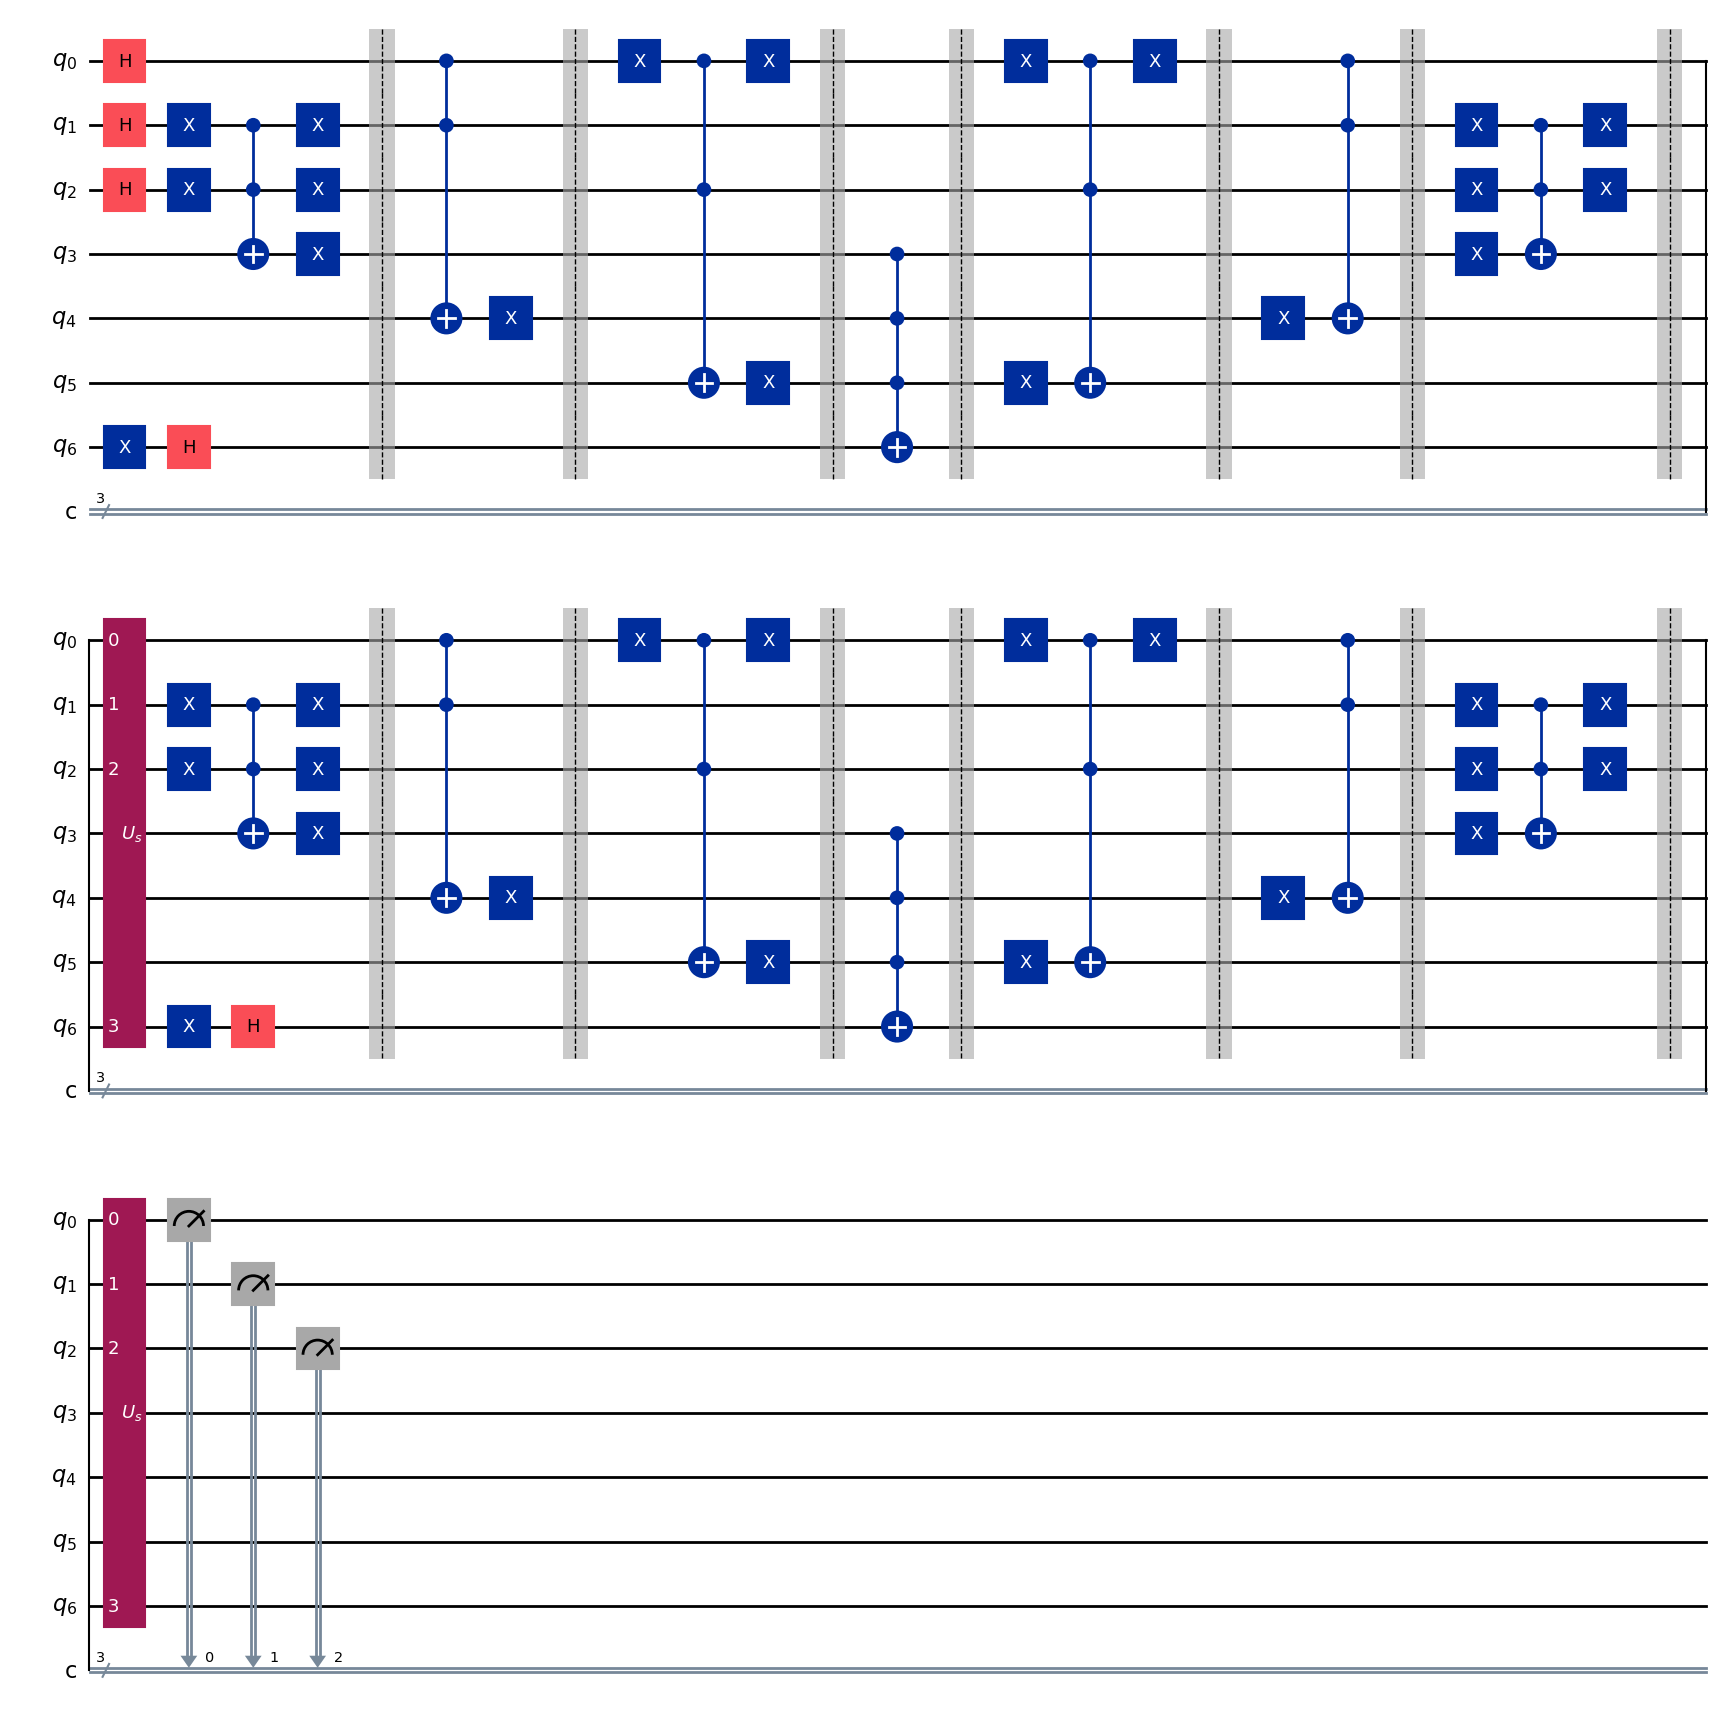

In [8]:
test = [[2, 3], [-1, -2], [1, -3]]
clauses =3
variables = 3
qc = QuantumCircuit(variables+clauses+1,variables)
for i in range(variables):
    qc.h(i)
Oracle = oracle(test,clauses,variables)
diff = diffuser(variables+1)
qubits =[]
for i in range(variables):
    qubits.append(i)
qubits.append(variables+clauses)
qc.compose(Oracle, inplace=True)
qc.compose(diff, inplace=True, qubits=qubits)
qc.compose(Oracle, inplace=True)
qc.compose(diff, inplace=True, qubits=qubits)
for i in range(variables):
    qc.measure([i], [i])
qc.draw('mpl')

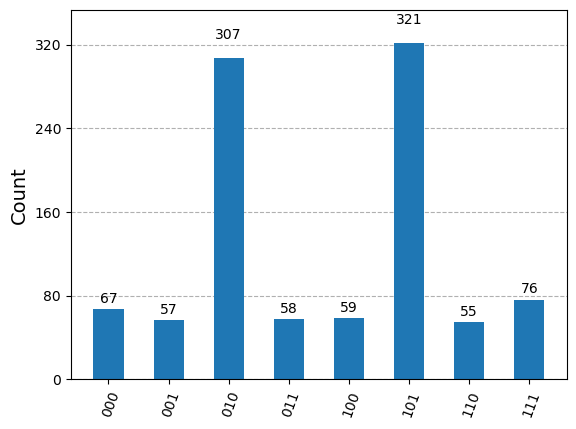

In [9]:
simulator = AerSimulator()
qcc = transpile(qc, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [11]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=2
)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()

{'000': 464, '100': 472, '001': 452, '110': 571, '010': 569, '011': 551, '111': 539, '101': 478}


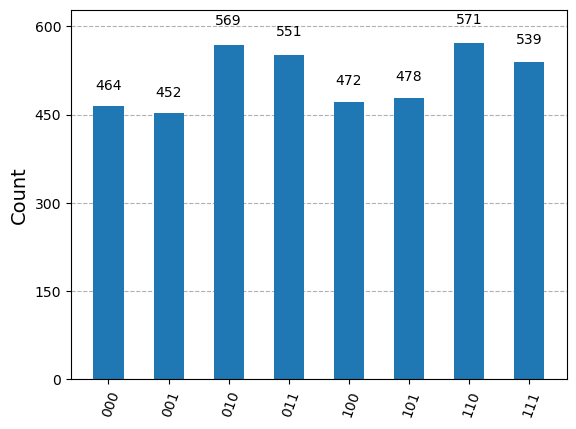

In [12]:
print(result[0].data.c.get_counts())
plot_histogram(result[0].data.c.get_counts())